Consider the data on log DPI (personal disposable income) introduced in Section 21.1
(see the book’s website for the actual data). Suppose you want to fit a suitable ARIMA
model to these data. Outline the steps involved in carrying out this task.

In [17]:

# Import required libraries
import pandas as pd
import numpy as np
from google.colab import files
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

dpi=pd.read_excel("./macro_data.xlsx")["DPI"]
dpi=dpi.dropna()
dpi


,DPI
1,0.014711
2,0.012397
3,-0.000049
4,0.013935
5,0.011554
...,...
83,-0.004946
84,-0.004174
85,0.006409
86,0.000706


In [18]:


# Function for unit root tests
def unit_root_tests(series, name):
    print(f"\nUnit Root Tests for {name}:")

    # ADF Test
    adf_result = adfuller(series)
    print("ADF Test:")
    print(f'ADF Statistic: {adf_result[0]:.4f}')
    print(f'p-value: {adf_result[1]:.4f}')
    print(f'Critical Values: {adf_result[4]}')

    # KPSS Test
    kpss_result = kpss(series)
    print("\nKPSS Test:")
    print(f'KPSS Statistic: {kpss_result[0]:.4f}')
    print(f'p-value: {kpss_result[1]:.4f}')
    print(f'Critical Values: {kpss_result[3]}')

# Perform unit root tests
unit_root_tests(dpi, "dpi")


Unit Root Tests for dpi:
ADF Test:
ADF Statistic: -4.6692
p-value: 0.0001
Critical Values: {'1%': np.float64(-3.512738056978279), '5%': np.float64(-2.8974898650628984), '10%': np.float64(-2.585948732897085)}

KPSS Test:
KPSS Statistic: 0.1970
p-value: 0.1000
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


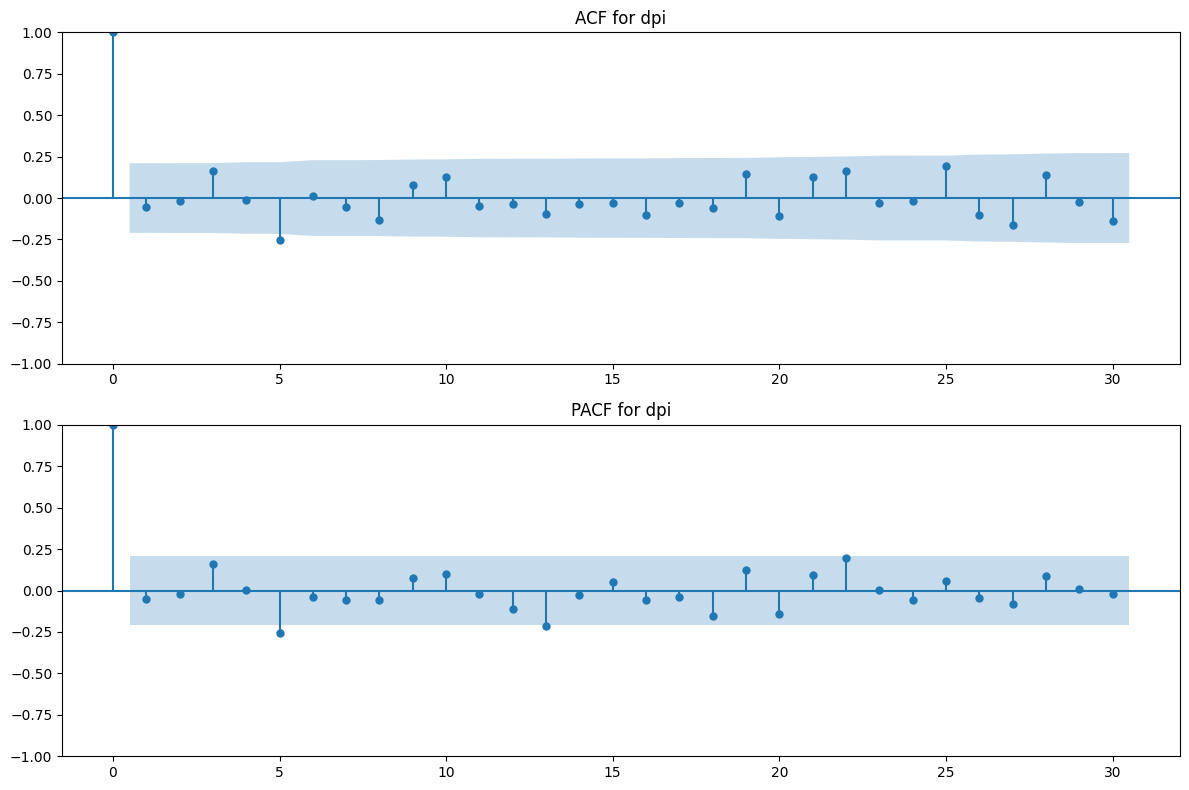


Correlogram Interpretation for dpi:
  - ACF: Shows total correlation at each lag, including indirect effects
  - PACF: Shows direct correlation at each lag, controlling for earlier lags
  - Significant spikes outside the blue confidence interval suggest strong correlations
  - ACF decay pattern indicates potential ARIMA model orders
  - PACF cutoff suggests AR order, while ACF cutoff suggests MA order


In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Function to plot correlograms with interpretation
def plot_correlograms(series, name, lags=30):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plot_acf(series, lags=lags, ax=plt.gca())
    plt.title(f'ACF for {name}')

    plt.subplot(2, 1, 2)
    plot_pacf(series, lags=lags, ax=plt.gca())
    plt.title(f'PACF for {name}')

    plt.tight_layout()
    plt.show()

    print(f"\nCorrelogram Interpretation for {name}:")
    print("  - ACF: Shows total correlation at each lag, including indirect effects")
    print("  - PACF: Shows direct correlation at each lag, controlling for earlier lags")
    print("  - Significant spikes outside the blue confidence interval suggest strong correlations")
    print("  - ACF decay pattern indicates potential ARIMA model orders")
    print("  - PACF cutoff suggests AR order, while ACF cutoff suggests MA order")

# Plot correlograms for original series
plot_correlograms(dpi, "dpi")



Best ARIMA model for dpi:
Order: (0, 0, 0)
AIC: -541.74
Interpretation:
  - p=0: 0 autoregressive term(s)
  - d=0: 0 difference(s) needed for stationarity
  - q=0: 0 moving average term(s)


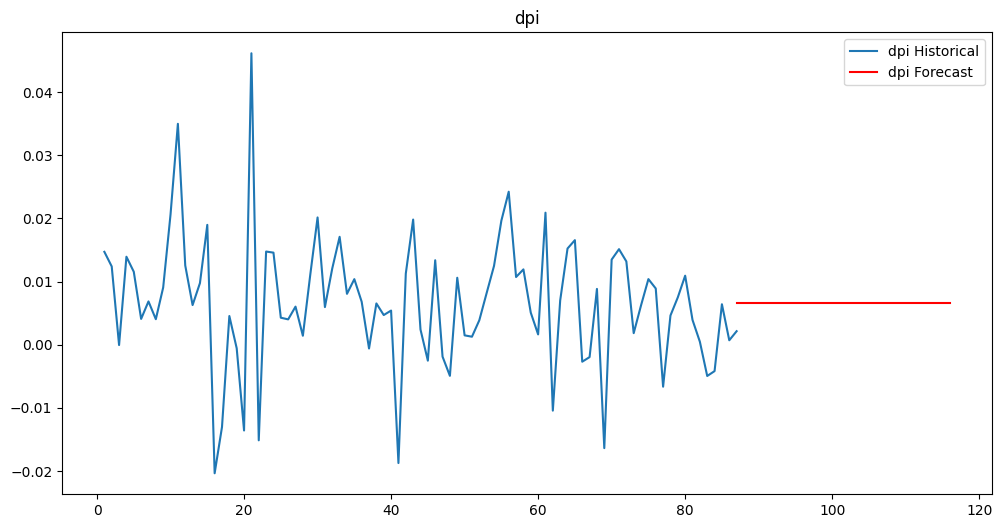

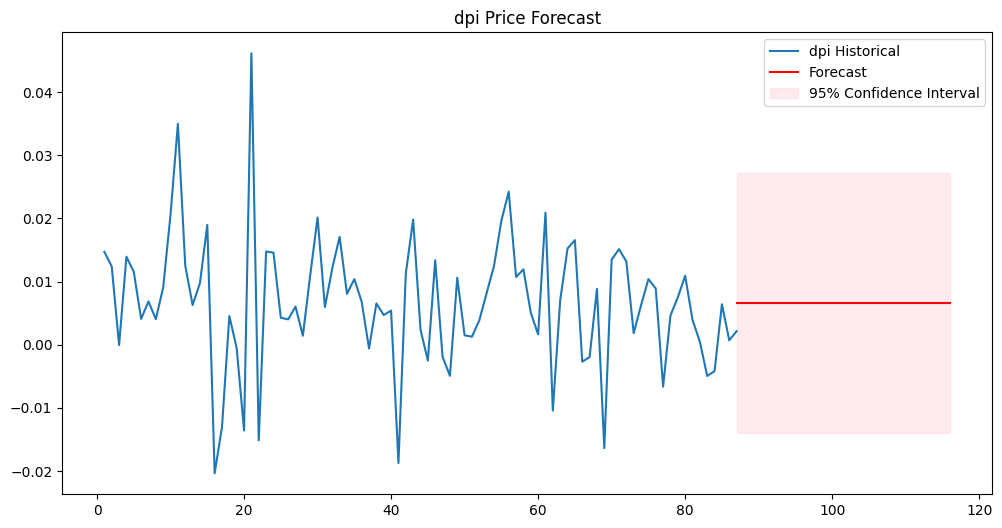


Forecast Interpretation for dpi:
Last observed value: 0.00
Average forecast value: 0.01
Forecast change: 0.00
Trend: Upward forecast trend
95% CI range at period 30: [-0.01, 0.03]
Interpretation: The wider the confidence interval, the less certain the forecast

dpi Forecast Values (next 5 periods):
87    0.006637
88    0.006637
89    0.006637
90    0.006637
91    0.006637
Name: predicted_mean, dtype: float64


In [20]:
# Function to find best ARIMA model with interpretation
def find_best_arima(series, name, max_p=3, max_d=2, max_q=3):
    best_aic = float('inf')
    best_order = None

    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(series, order=(p, d, q))
                    results = model.fit()
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_order = (p, d, q)
                except:
                    continue

    print(f"\nBest ARIMA model for {name}:")
    print(f"Order: {best_order}")
    print(f"AIC: {best_aic:.2f}")
    print("Interpretation:")
    print(f"  - p={best_order[0]}: {best_order[0]} autoregressive term(s)")
    print(f"  - d={best_order[1]}: {best_order[1]} difference(s) needed for stationarity")
    print(f"  - q={best_order[2]}: {best_order[2]} moving average term(s)")
    return best_order

# Find and fit best ARIMA models
dpi_order = find_best_arima(dpi, "dpi")

# Fit final ARIMA models
dpi_model = ARIMA(dpi, order=dpi_order).fit()

# Forecast next 30 periods
forecast_steps = 30
dpi_forecast = dpi_model.forecast(steps=forecast_steps)

# Create forecast index
last_index = len(dpi) - 1
forecast_index = range(last_index + 1, last_index + 1 + forecast_steps)

# Plot original series with forecasts
plt.figure(figsize=(12,6))
plt.plot(dpi, label='dpi Historical')
plt.plot(forecast_index, dpi_forecast, label='dpi Forecast', color='red')
plt.title('dpi')
plt.legend()
plt.show()

# Detailed forecast plot with confidence intervals and interpretation
def plot_forecast(model, series, name, steps=30):
    forecast_obj = model.get_forecast(steps=steps)
    forecast = forecast_obj.predicted_mean
    conf_int = forecast_obj.conf_int()

    forecast_index = range(len(series), len(series) + steps)

    plt.figure(figsize=(12,6))
    plt.plot(series, label=f'{name} Historical')
    plt.plot(forecast_index, forecast, label='Forecast', color='red')
    plt.fill_between(forecast_index,
                    conf_int.iloc[:, 0],
                    conf_int.iloc[:, 1],
                    color='pink',
                    alpha=0.3,
                    label='95% Confidence Interval')
    plt.title(f'{name} Price Forecast')
    plt.legend()
    plt.show()

    # Forecast interpretation
    last_value = series.iloc[-1]
    mean_forecast = forecast.mean()
    print(f"\nForecast Interpretation for {name}:")
    print(f"Last observed value: {last_value:.2f}")
    print(f"Average forecast value: {mean_forecast:.2f}")
    print(f"Forecast change: {mean_forecast - last_value:.2f}")
    if mean_forecast > last_value:
        print("Trend: Upward forecast trend")
    elif mean_forecast < last_value:
        print("Trend: Downward forecast trend")
    else:
        print("Trend: Flat forecast trend")
    print(f"95% CI range at period {steps}: [{conf_int.iloc[-1, 0]:.2f}, {conf_int.iloc[-1, 1]:.2f}]")
    print("Interpretation: The wider the confidence interval, the less certain the forecast")

# Generate detailed forecast plots and interpretations
plot_forecast(dpi_model,dpi, name="dpi")


# Print forecast values
print("\ndpi Forecast Values (next 5 periods):")
print(dpi_forecast[:5])

In [22]:
print(dpi_model.summary())

                               SARIMAX Results                                
Dep. Variable:                    DPI   No. Observations:                   87
Model:                          ARIMA   Log Likelihood                 272.868
Date:                Sat, 01 Nov 2025   AIC                           -541.737
Time:                        00:51:04   BIC                           -536.805
Sample:                             0   HQIC                          -539.751
                                 - 87                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0066      0.001      5.859      0.000       0.004       0.009
sigma2         0.0001   1.18e-05      9.384      0.000    8.74e-05       0.000
Ljung-Box (L1) (Q):                   0.25   Jarque-

In [21]:
# PARA EXPORTAR

from google.colab import files
import nbformat
from nbconvert import HTMLExporter

# Paso 1: Cargar tu archivo .ipynb
print("Por favor, selecciona tu archivo .ipynb")
uploaded = files.upload()

# Paso 2: Obtener el nombre del archivo cargado
notebook_filename = list(uploaded.keys())[0]
print(f"\nArchivo cargado: {notebook_filename}")

# Paso 3: Leer el notebook
with open(notebook_filename, 'r', encoding='utf-8') as f:
    notebook = nbformat.read(f, as_version=4)

# Paso 4: Convertir a HTML
print("Convirtiendo a HTML...")
html_exporter = HTMLExporter()
html_exporter.template_name = 'classic'
(body, resources) = html_exporter.from_notebook_node(notebook)

# Paso 5: Guardar el archivo HTML
html_filename = notebook_filename.replace('.ipynb', '.html')
with open(html_filename, 'w', encoding='utf-8') as f:
    f.write(body)

print(f"Conversión completada: {html_filename}")

# Paso 6: Descargar el archivo HTML
print("Descargando archivo HTML...")
files.download(html_filename)
print("¡Listo! Tu archivo HTML ha sido descargado.")

Por favor, selecciona tu archivo .ipynb


Saving 18.ipynb to 18.ipynb

Archivo cargado: 18.ipynb
Convirtiendo a HTML...
Conversión completada: 18.html
Descargando archivo HTML...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

¡Listo! Tu archivo HTML ha sido descargado.
